# EDA

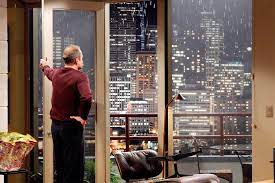

In [1]:
import warnings

warnings.filterwarnings("ignore")

import geopy.distance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Importing the data
Get the data we saved into the `.csv` file into a pandas DataFrame by using the read_csv method.

In [2]:
df_raw = pd.read_csv('data/king_county_house_data.csv')

## Data Cleaning

First we want to get a feel for the data we have by using the methods of pandas that give us an overview (`.head()`, `.describe()`, `.info()`, ...) and prepare the data for our EDA.

In [3]:
df_raw.info()
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   house_id       21597 non-null  int64  
 3   id             21597 non-null  int64  
 4   id.1           21597 non-null  int64  
 5   bedrooms       21597 non-null  float64
 6   bathrooms      21597 non-null  float64
 7   sqft_living    21597 non-null  float64
 8   sqft_lot       21597 non-null  float64
 9   floors         21597 non-null  float64
 10  waterfront     19206 non-null  float64
 11  view           21534 non-null  float64
 12  condition      21597 non-null  int64  
 13  grade          21597 non-null  int64  
 14  sqft_above     21597 non-null  float64
 15  sqft_basement  21145 non-null  float64
 16  yr_built       21597 non-null  int64  
 17  yr_renovated   17749 non-null  float64
 18  zipcod

,date,price,house_id,id,id.1,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.000,7129300520,1,7129300520,3.000,1.000,1180.000,5650.000,1.000,...,7,1180.000,0.000,1955,0.000,98178,47.511,-122.257,1340.000,5650.000
1,2014-12-09,538000.000,6414100192,2,6414100192,3.000,2.250,2570.000,7242.000,2.000,...,7,2170.000,400.000,1951,19910.000,98125,47.721,-122.319,1690.000,7639.000
2,2015-02-25,180000.000,5631500400,3,5631500400,2.000,1.000,770.000,10000.000,1.000,...,6,770.000,0.000,1933,NaN,98028,47.738,-122.233,2720.000,8062.000
3,2014-12-09,604000.000,2487200875,4,2487200875,4.000,3.000,1960.000,5000.000,1.000,...,7,1050.000,910.000,1965,0.000,98136,47.521,-122.393,1360.000,5000.000
4,2015-02-18,510000.000,1954400510,5,1954400510,3.000,2.000,1680.000,8080.000,1.000,...,8,1680.000,0.000,1987,0.000,98074,47.617,-122.045,1800.000,7503.000


Luckily the column names are all already pythonic, so we don't need to change them. There are some columns we don't need though.

The column `house_id` and `id.1` are the same, this stems from joining the two tables on those columns. We can drop the `id.1` column without losing data to make the table more readable.

In [4]:
df_all_relevant_columns = df_raw.drop(columns =['id.1', 'id'])
df_all_relevant_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21597 non-null  object 
 1   price          21597 non-null  float64
 2   house_id       21597 non-null  int64  
 3   bedrooms       21597 non-null  float64
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  float64
 6   sqft_lot       21597 non-null  float64
 7   floors         21597 non-null  float64
 8   waterfront     19206 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  float64
 13  sqft_basement  21145 non-null  float64
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17749 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

That looks a bit better. Now that we have all the columns we need, we can focus on the kind of data in those columns. First, let's convert the `date` column into a Timestamp. 

In [5]:
df_all_relevant_columns['date'] = pd.to_datetime(df_all_relevant_columns['date'], format = '%Y-%m-%d')
df_all_relevant_columns['date'].dtype

dtype('<M8[ns]')

There are a lot of float values, where the actual value only consists of integers. Let's change the dtype to reflect that. To be sure, let's check if all the values in those columns are actually integers.

In [6]:
# all the float columns that could also be integers
int_columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'yr_renovated', 'sqft_living15', 'sqft_lot15']

# check if all the values are integers and return a touple of the column-name and the test
list(zip(int_columns, (all(x.is_integer() for x in df_all_relevant_columns[col]) for col in int_columns)))

[('price', True),
 ('bedrooms', True),
 ('bathrooms', False),
 ('sqft_living', True),
 ('sqft_lot', True),
 ('floors', False),
 ('sqft_above', True),
 ('sqft_basement', False),
 ('yr_renovated', False),
 ('sqft_living15', True),
 ('sqft_lot15', True)]

As we can see, for all columns except `bathrooms`, `floors`, `sqft_basement` and `yr_renovated` this is already the case. Let's look at those four a bit closer to see what is going on there. 

In [7]:
# create a copy of the relevant columns
df_int_columns = df_all_relevant_columns[['bathrooms', 'floors', 'sqft_basement', 'yr_renovated']]
# check all the values to see if they are rational or whole numbers
df_find_rationals_mask = df_int_columns.applymap(lambda x: True if x%1 == 0 else False)
# filter out all the whole numbers to find the rationals
df_int_columns_outliers = df_int_columns[df_find_rationals_mask]
# drop all columns where all the values are whole numbers
# df_int_columns_outliers.dropna(how='all', inplace=True)
df_int_columns_outliers.isna().sum()


bathrooms        14898
floors            2078
sqft_basement      452
yr_renovated      3848
dtype: int64

Now that we have the outliers, let's look at the four columns individually. The `bathrooms` column has only quarters (X.0, X.25, X.5, X.75), the `floors` columns has only halves (X.0, X.5) So we can assume that those numbers come from partial bathrooms (just a sink or a guest bathroom for example) or smaller floors that are counted as half a floor.

The other two columns contain missing data, that returns false when the `.is_int()` method is called on it.

So we can go ahead and convert all the columns to int, except for `bathrooms` and `floors`.

we can also change the Waterfront and the View columns to boolean.

In [8]:
float_to_int_columns = ['price', 'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_renovated', 'sqft_living15', 'sqft_lot15']
df_all_relevant_columns[float_to_int_columns] = df_all_relevant_columns[float_to_int_columns].astype('Int64')
df_all_relevant_columns[['waterfront', 'view']] = df_all_relevant_columns[['waterfront', 'view']].replace({1:True, 0:False}).astype(bool)
df_all_relevant_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21597 non-null  datetime64[ns]
 1   price          21597 non-null  Int64         
 2   house_id       21597 non-null  int64         
 3   bedrooms       21597 non-null  Int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  Int64         
 6   sqft_lot       21597 non-null  Int64         
 7   floors         21597 non-null  float64       
 8   waterfront     21597 non-null  bool          
 9   view           21597 non-null  bool          
 10  condition      21597 non-null  int64         
 11  grade          21597 non-null  int64         
 12  sqft_above     21597 non-null  Int64         
 13  sqft_basement  21145 non-null  Int64         
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   1774

Now let's look at the missing data. There is data missing in columns `waterfront`, `view`, `sqft_basement` and `yr_renovated`. since our client William Rodriguez is not interested in any of those specific values, the missing data there is fine and we can keep going.

The `yr_renovated`column has a lot of `0` values, and all the years are multiplied by 10. Let's rectify that.

In [9]:
df_all_relevant_columns['yr_renovated'] = df_all_relevant_columns['yr_renovated'].apply(lambda x: x/10 if x>0 else x)
df_all_relevant_columns['yr_renovated'] = df_all_relevant_columns['yr_renovated'].astype('Int64')

Now that the year renovated column is clean as well, we can start exploring the data.

## Hypotheses

- The closer to the city center, the more expensive the house is gonna be.  <!-- Wrong, there is no correlation-->
- The larger the house, the more expensive it's gonna be. <!-- True, there is a high correlation (0.7)-->
- The higher the grade of the house, the more expensive it's gonna be.  <!-- True, there is a high correlation (0.67)-->

### Assumptions needed for the Hypotheses

- The city center is the Seattle space needle. (lat = 47.6205 , long = -122.3493)

In [10]:
space_needle_coords = (47.6205, -122.3493)

### City House

Assumptions:
The closer to the city center, the better. 
To calculate that distance, we use the `geopy` module that calculates the distance between two points based on the coordinates. For more info see the [geopy documentation](https://geopy.readthedocs.io/en/stable/)

They want a house of at least average grade and condition, the higher the better. They need between 2 and 3 bedrooms, and no more than 2 bathrooms. The square footage of living space should be the average of the houses in the city or more. 

Here we first create a column coordinates, and then we calculate the distance with the help of geopy.

In [11]:

df_all_relevant_columns['coordinates'] = list(zip(df_all_relevant_columns['lat'],df_all_relevant_columns['long']))
df_all_relevant_columns['needle_dist_in_km'] = df_all_relevant_columns['coordinates'].apply(lambda x: geopy.distance.geodesic(space_needle_coords, x).km)
df_all_relevant_columns['year_of_sale'] = df_all_relevant_columns['date'].apply(lambda x: int(x.year))
df_all_relevant_columns['month_of_sale'] = df_all_relevant_columns['date'].apply(lambda x: int(x.month))
df_all_relevant_columns['week_of_sale'] = df_all_relevant_columns['date'].apply(lambda x: int(x.week))
df_all_relevant_columns.eval('lot_to_living_ratio = sqft_lot / sqft_living', inplace=True)
df_all_relevant_columns.eval('lot_to_living15_ratio = sqft_lot15 / sqft_living15', inplace=True)


In [22]:


df_city_house_selection = df_all_relevant_columns.drop(columns=['floors', 'waterfront', 'view', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'yr_renovated', 'yr_built', 'sqft_above', 'zipcode', 'coordinates', 'lot_to_living_ratio']).query('bedrooms < 4 and bedrooms > 1 and bathrooms > 2.25 and grade > 7 and condition > 3 and needle_dist_in_km < 5')
df_city_house_selection.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 100 to 21196
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   40 non-null     datetime64[ns]
 1   price                  40 non-null     Int64         
 2   house_id               40 non-null     int64         
 3   bedrooms               40 non-null     Int64         
 4   bathrooms              40 non-null     float64       
 5   sqft_living            40 non-null     Int64         
 6   sqft_lot               40 non-null     Int64         
 7   condition              40 non-null     int64         
 8   grade                  40 non-null     int64         
 9   lat                    40 non-null     float64       
 10  long                   40 non-null     float64       
 11  needle_dist_in_km      40 non-null     float64       
 12  year_of_sale           40 non-null     int64         
 13  month_o

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, 391 to 18753
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   28 non-null     datetime64[ns]
 1   price                  28 non-null     Int64         
 2   house_id               28 non-null     int64         
 3   bedrooms               28 non-null     Int64         
 4   bathrooms              28 non-null     float64       
 5   sqft_living            28 non-null     Int64         
 6   sqft_lot               28 non-null     Int64         
 7   condition              28 non-null     int64         
 8   grade                  28 non-null     int64         
 9   yr_renovated           28 non-null     Int64         
 10  lat                    28 non-null     float64       
 11  long                   28 non-null     float64       
 12  sqft_living15          28 non-null     Int64         
 13  sqft_lo

<Axes: xlabel='needle_dist_in_km', ylabel='lot_to_living_ratio'>

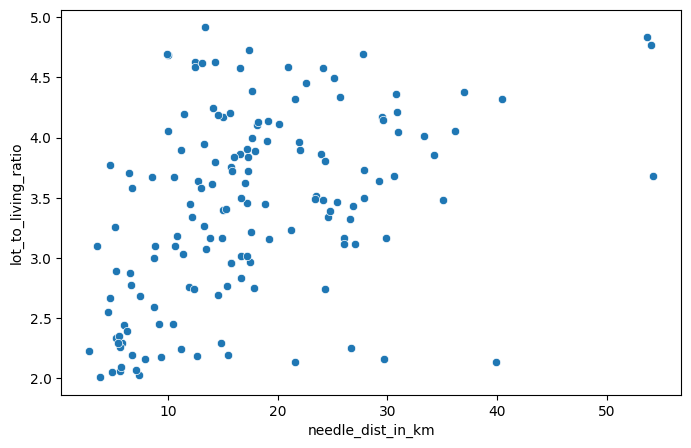

In [13]:

df_country_house_selection = df_all_relevant_columns.drop(columns=['floors', 'waterfront', 'view', 'sqft_basement', 'yr_built', 'sqft_above', 'zipcode', 'coordinates']).query('bedrooms < 4 and bedrooms > 1 and bathrooms > 2.25 and grade > 7 and condition > 3')
df_country_house_selection.query('yr_renovated < 1 and lot_to_living15_ratio < 2').info()
# df_country_houses_selection.query('lot_to_living_ratio < 10').info()
sns.scatterplot(df_country_house_selection.query('yr_renovated < 1 and lot_to_living_ratio < 5 and lot_to_living_ratio > 2'), x='needle_dist_in_km', y='lot_to_living_ratio')

## Data Exploration

In [14]:
df_all_relevant_columns.describe()

,date,price,house_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,...,lat,long,sqft_living15,sqft_lot15,needle_dist_in_km,year_of_sale,month_of_sale,week_of_sale,lot_to_living_ratio,lot_to_living15_ratio
count,21597,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,...,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000,21597.000
mean,2014-10-29 04:20:38.171968512,540296.574,4580474287.771,3.373,2.116,2080.322,15099.409,1.494,3.410,7.658,...,47.560,-122.214,1986.620,12758.284,19.225,2014.323,6.574,26.864,7.432,6.346
min,2014-05-02 00:00:00,78000.000,1000102.000,1.000,0.500,370.000,520.000,1.000,1.000,3.000,...,47.156,-122.519,399.000,651.000,0.754,2014.000,1.000,1.000,0.215,0.446
25%,2014-07-22 00:00:00,322000.000,2123049175.000,3.000,1.750,1430.000,5040.000,1.000,3.000,7.000,...,47.471,-122.328,1490.000,5100.000,9.874,2014.000,4.000,16.000,2.453,2.657
50%,2014-10-16 00:00:00,450000.000,3904930410.000,3.000,2.250,1910.000,7618.000,1.500,3.000,7.000,...,47.572,-122.231,1840.000,7620.000,17.108,2014.000,6.000,26.000,4.038,4.061
75%,2015-02-17 00:00:00,645000.000,7308900490.000,4.000,2.500,2550.000,10685.000,2.000,4.000,8.000,...,47.678,-122.125,2360.000,10083.000,26.667,2015.000,9.000,38.000,6.383,5.753
max,2015-05-27 00:00:00,7700000.000,9900000190.000,33.000,8.000,13540.000,1651359.000,3.500,5.000,13.000,...,47.778,-121.315,6210.000,871200.000,78.358,2015.000,12.000,52.000,1640.555,689.972
std,NaN,367368.140,2876735715.748,0.926,0.769,918.106,41412.637,0.540,0.651,1.173,...,0.139,0.141,685.230,27274.442,11.336,0.468,3.115,13.494,22.657,13.934


Testing the hypotheses:

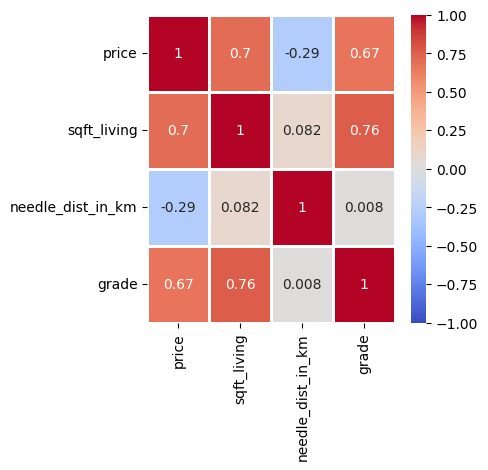

In [15]:
plt.figure(figsize=(4,4),dpi=100)
sns.heatmap(
    data=df_all_relevant_columns[['price', 'sqft_living', 'needle_dist_in_km', 'grade']].corr(),
    cmap='coolwarm',
    linecolor='white',
    linewidth=1,
    annot=True,
    vmin=-1,
    vmax=1
);

This heatmap shows that there is most likely a strong correlation between price and grade, and price and sqft_living, but not between price and needle_dist_in_km

We can basically split the requirements up into two seperate parts:
- A city house (fast & central location)
- A country house (best timing & non-renovated)

Now that we have that column, we have to see if there is a correlation between the distance to the city centre, and the price of the house.

In [16]:
# sns.scatterplot(df_all_relevant_columns, x = 'date', y = 'price', hue='grade')
pd.crosstab(df_all_relevant_columns.grade, df_all_relevant_columns.condition)

condition,1,2,3,4,5
grade,,,,,
3,0,0,0,0,1
4,1,4,12,10,0
5,9,15,100,84,34
6,11,59,1035,685,248
7,6,75,5229,2831,833
8,2,13,4266,1394,390
9,0,2,2041,446,126
10,0,2,921,156,55
11,0,0,332,56,11


UFuncTypeError: ufunc 'multiply' cannot use operands with types dtype('O') and dtype('<m8[ns]')

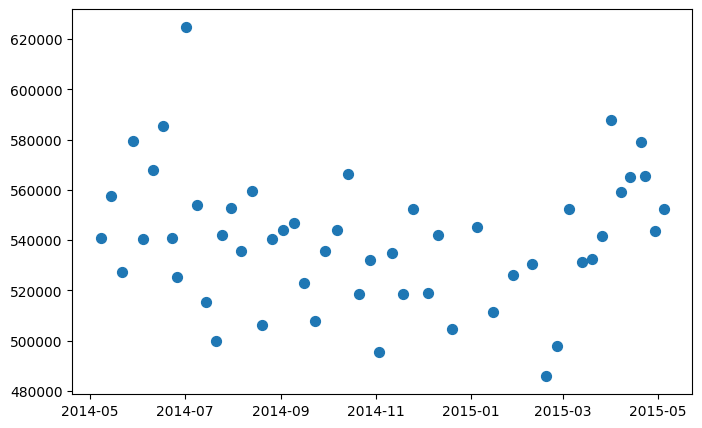

In [17]:
# sns.lineplot(df_all_relevant_columns[['week_of_sale', 'price']], x='week_of_sale', y='price')

fig, ax = plt.subplots()
# df_all_relevant_columns.groupby('week_of_sale')['price'].mean˜().plot(kind='line')

sns.regplot(df_all_relevant_columns, x='date', y='price', x_bins=52, ax=ax, ci=0, lowess=True)

plt.xticks(rotation=90)

plt.show()

All we see here for now is that the higher the grade of the house, the higher the price. let's look at that in a little more detail, to see if there is a correlation in the subgroups.

In [15]:
# Define
# seattle_zipcodes = list(range(98100,98200))

# df_city_houses = df_all_relevant_columns.query(f'zipcode in {seattle_zipcodes}')
# df_country_houses = df_all_relevant_columns.query(f'not (zipcode in {seattle_zipcodes})')


In [23]:
df_city_house_locations = df_city_house_selection[['house_id', 'lat', 'long']].copy()
df_city_house_locations.columns = ['name', 'latitude', 'longitude']
df_city_house_locations.to_csv('data/city_house_locations.csv', index=False)
df_city_house_locations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 100 to 21196
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       40 non-null     int64  
 1   latitude   40 non-null     float64
 2   longitude  40 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.2 KB


<Axes: xlabel='lot_to_living_ratio', ylabel='needle_dist_in_km'>

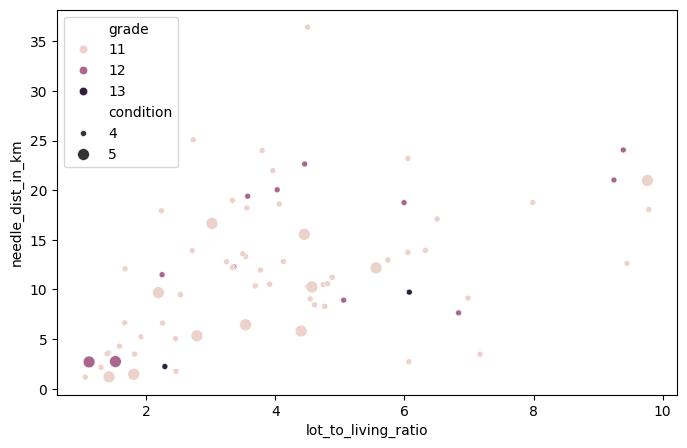

In [ ]:
df_all_relevant_columns.eval('lot_to_living_ratio = sqft_lot / sqft_living', inplace=True)
# sns.lineplot(data=df_all_relevant_columns, x='date', y='price', hue='condition')

# sns.boxplot(data=df_all_relevant_columns[['lot_to_living_ratio']], y)
sns.scatterplot(data=df_all_relevant_columns.query('lot_to_living_ratio < 10 and grade > 10 and condition > 3'), x='lot_to_living_ratio', y='needle_dist_in_km', hue='grade', size='condition')

In [18]:
df_country_house_locations = df_country_house_selection[['house_id', 'lat', 'long']].copy()
df_country_house_locations.columns = ['name', 'latitude', 'longitude']
df_country_house_locations.to_csv('data/country_house_locations.csv', index=False)
df_country_house_locations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 49 to 21196
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       400 non-null    int64  
 1   latitude   400 non-null    float64
 2   longitude  400 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 12.5 KB
